In [1]:
import torch
from torch import nn
import torchvision
from torchvision.datasets import EMNIST
from torchvision.transforms import ToTensor, Pad, Compose
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image, ImageChops
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

torch.set_printoptions(threshold=100, linewidth=160, edgeitems=4, precision=3)

# BIT AI - 05 Computer Vision

## Part I - Kernels, binarization and basic operations




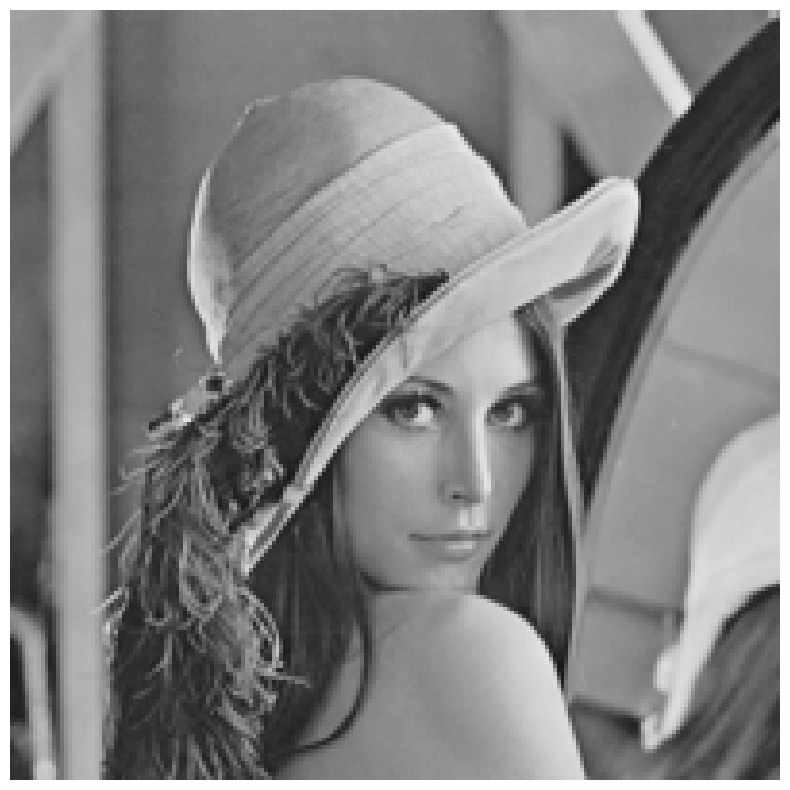

In [2]:
def get_img(url, color=False, size=200):
    img = Image.open(urlopen(url))
    if not color:
        img = img.convert("L")
    if size:
        img = img.resize((size, size))
    return np.array(img)


def display(img):
    fig = plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(img, cmap="gray", vmin=0, vmax=255)


img = get_img("https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png")
display(img)

In [3]:
from scipy.signal import convolve2d

kernel = np.ones((2, 50), np.float32) / 100
kernel

array([[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01]], dtype=float32)

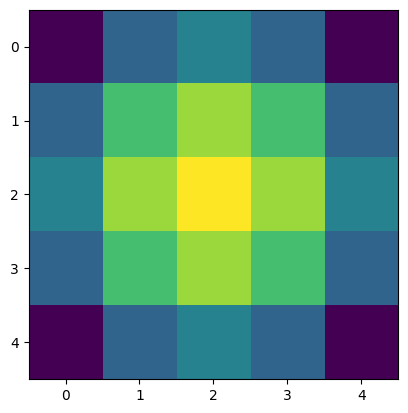

In [4]:
import numpy as np
from scipy import signal


def gkern(kernlen=5, std=3):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d / gkern2d.sum()


gaussian_kernel = gkern(5)

plt.imshow(gaussian_kernel)

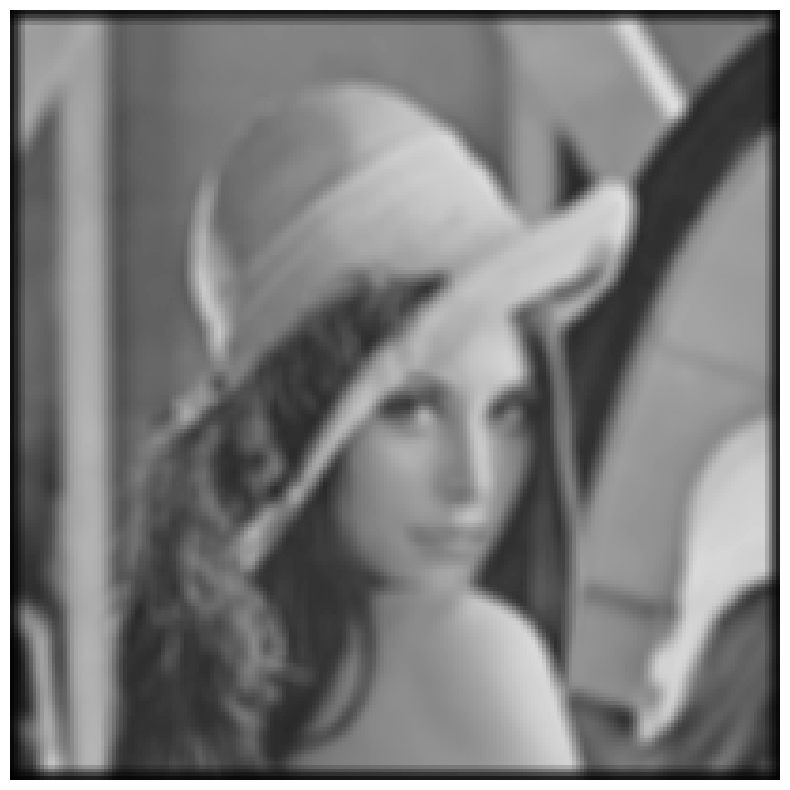

In [5]:
filtered_img = convolve2d(img, gaussian_kernel)
display(filtered_img)

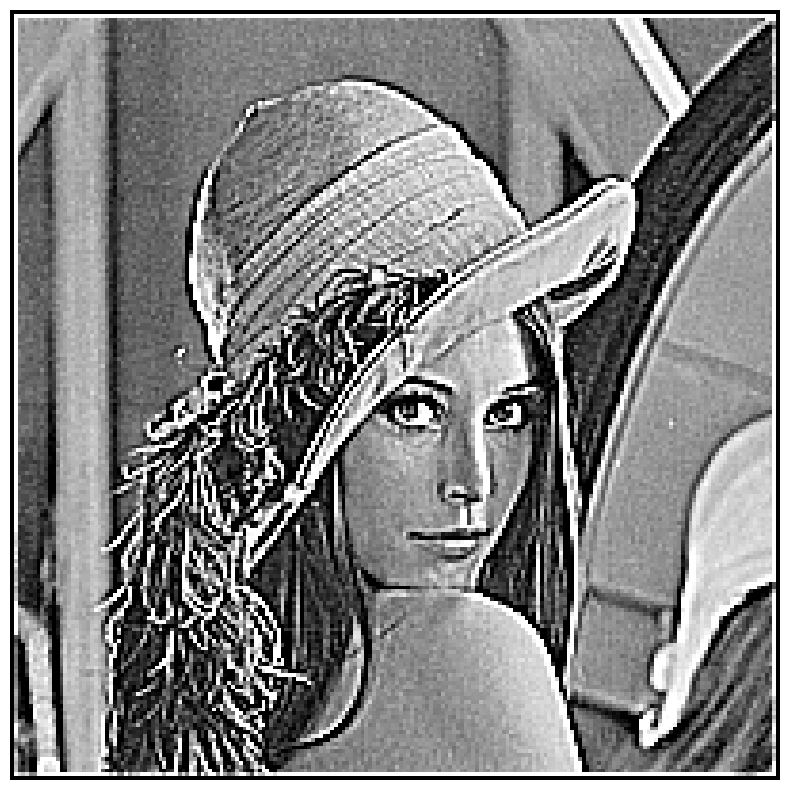

In [6]:
# Sharpen
kernel = [[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]

filtered_img = convolve2d(img, kernel)
display(filtered_img)

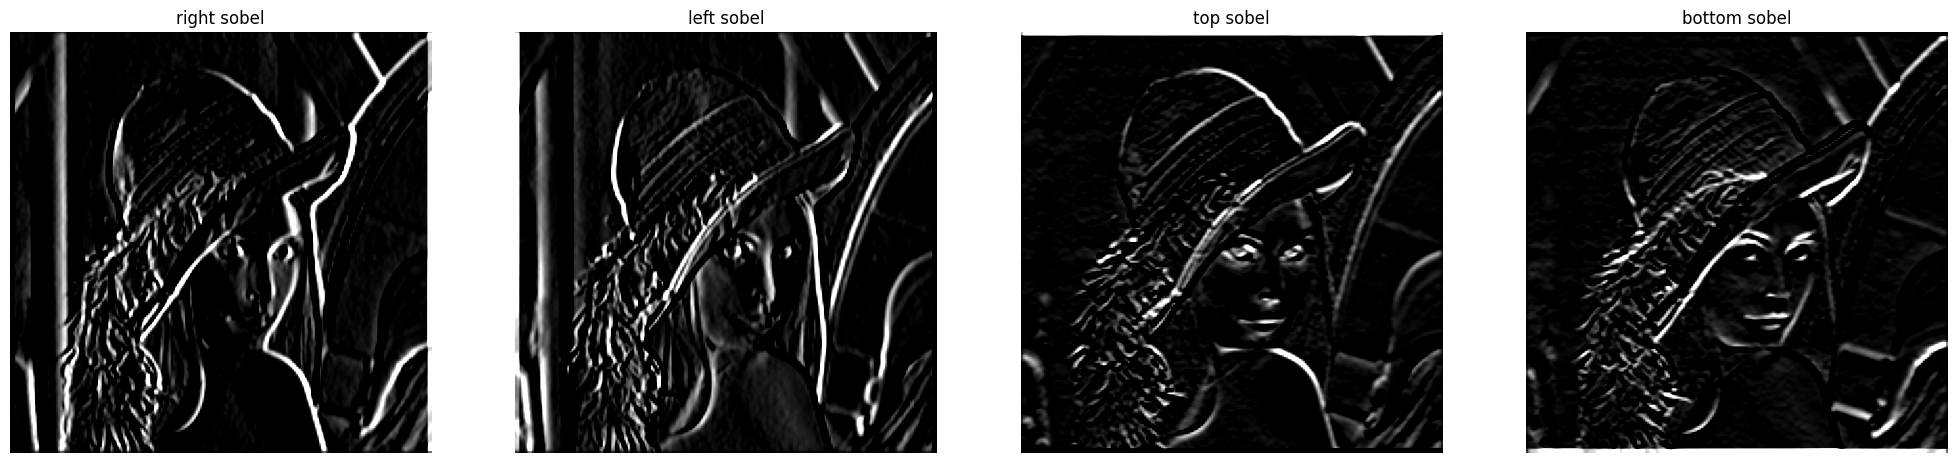

In [7]:
kernels = {
    "right sobel": [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]],
    "left sobel": [[1, 0, -1], [2, 0, -2], [1, 0, -1]],
    "top sobel": [[1, 2, 1], [0, 0, 0], [-1, -2, -1]],
    "bottom sobel": [[-1, -2, -1], [0, 0, 0], [1, 2, 1]],
}

fig, ax = plt.subplots(ncols=4, figsize=(25, 12))

for i, (name, kernel) in enumerate(kernels.items()):
    ax[i].imshow(convolve2d(img, kernel), cmap="gray", vmin=0, vmax=255)
    ax[i].set_title(name)
    ax[i].axis("off")

### Zadanie I

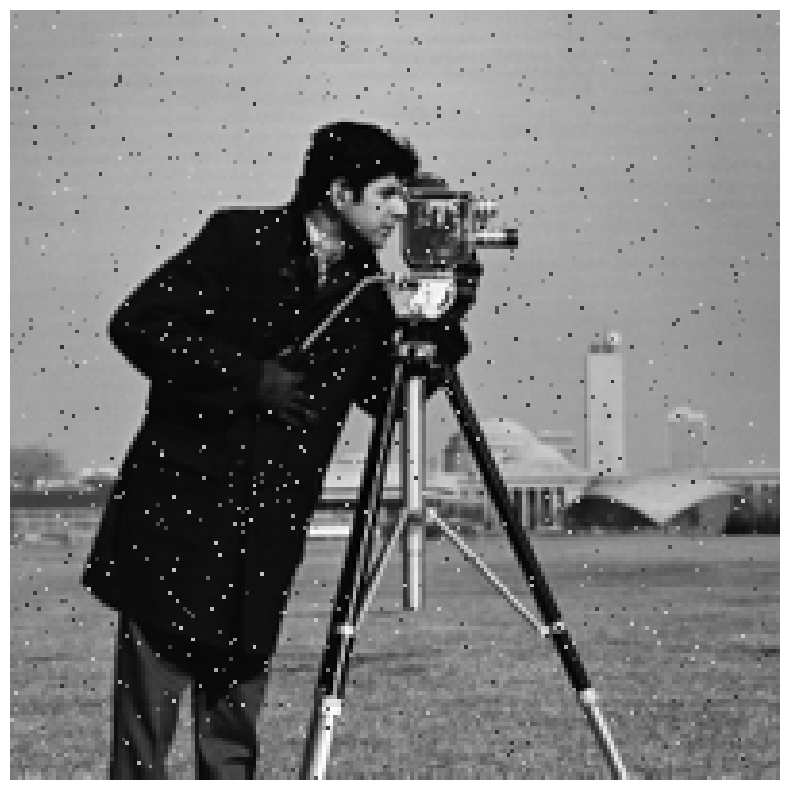

In [8]:
img_with_noise = get_img("https://pbs.twimg.com/media/D8QFibRVUAANxfU.png")
img_with_noise[np.random.randint(0, 200, 1000), np.random.randint(0, 200, 1000)] = np.random.randint(50, 200, 1000)
display(img_with_noise)


Napisz funkcję, która binaryzuje to zdjęcie.
- postaraj się usunąc szum
- ustal próg, który wydaje się dobrze działać
- na wyjściu chcemy, żeby facet był biały, a tło czarne


In [9]:
blured = ...



---


## Part II - Convolutional Neural Networks

In [10]:
torch.manual_seed(0)
train_set = EMNIST(
    "data", split="balanced", download=True, train=True, transform=Compose([ToTensor(), Pad(2)])
)

train_set = Subset(train_set, np.arange(15000))

test_set = EMNIST(
    "data", split="balanced", download=True, train=False, transform=Compose([ToTensor(), Pad(2)])
)

classes = test_set.classes

print(f"Train size: {len(train_set)}")
print(f"Test size: {len(test_set)}")
print(f"Classes: {classes}")
print(f"Img shape: {train_set[0][0].shape}")

Train size: 15000
Test size: 18800
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
Img shape: torch.Size([1, 32, 32])


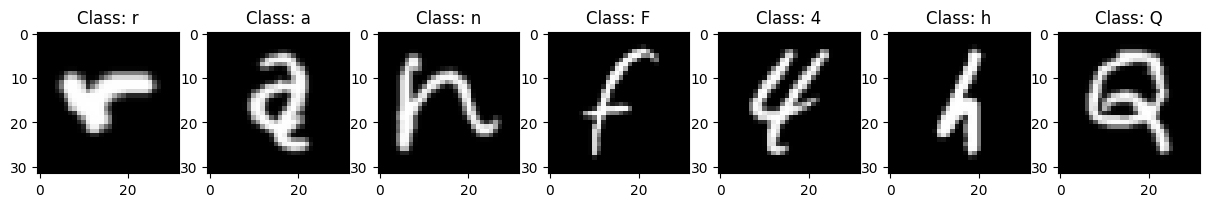

In [11]:
fig, axs = plt.subplots(ncols=7, figsize=(15, 5))
for i, ax in enumerate(axs):
    img, label = train_set[i]
    ax.imshow(img[0].transpose(0, 1), cmap="gray")
    ax.set_title(f"Class: {classes[label]}")

<Axes: >

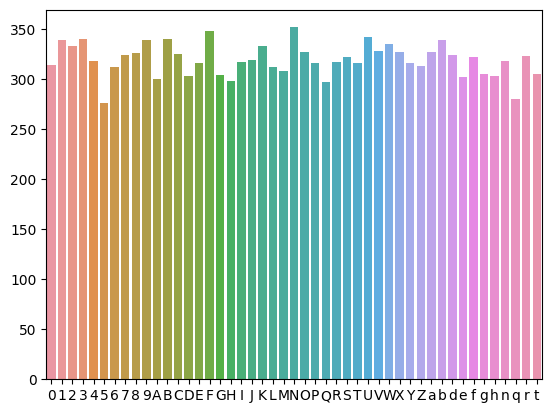

In [12]:
_, counts = np.unique([y for X, y in train_set], return_counts=True)
sns.barplot(y=counts, x=classes)

In [13]:
class BasicCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=7, padding="same")
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=11, kernel_size=4, stride=3)
        self.conv3 = nn.Conv2d(in_channels=11, out_channels=128, kernel_size=5)

        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.linear = nn.Linear(in_features=128, out_features=n_classes)

        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)  # [bs, 1, 32, 32] -> [bs, 3, 32, 32]
        x = self.act(x)
        x = self.pool(x)  # [bs, 3, 32, 32] -> [bs, 3, 16, 16]
        x = self.conv2(x)  # [bs, 3, 16, 16]  -> [bs, 11, 5, 5]
        x = self.act(x)
        x = self.conv3(x)  # [bs, 11, 5, 5]  -> [bs, 128, 1, 1]
        x = self.act(x)
        x = x.flatten(start_dim=1)  # [bs, 128, 1, 1] - > [bs, 128]
        x = self.linear(x)  # [bs, 128]  -> [bs, n_classes]

        return x

In [14]:
cnn = BasicCNN(n_classes=10)
cnn

BasicCNN(
  (conv1): Conv2d(1, 3, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (conv2): Conv2d(3, 11, kernel_size=(4, 4), stride=(3, 3))
  (conv3): Conv2d(11, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (linear): Linear(in_features=128, out_features=10, bias=True)
  (act): ReLU()
)

In [15]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])


count_parameters(cnn)

37307

In [16]:
example = torch.unsqueeze(train_set[0][0], dim=0)
example.shape

torch.Size([1, 1, 32, 32])

In [17]:
cnn(example)

tensor([[-0.032,  0.006, -0.011,  0.092, -0.028, -0.059, -0.035,  0.039, -0.098, -0.087]], grad_fn=<AddmmBackward0>)

In [18]:
def train(model, train_set, batch_size=256, learning_rate=0.005, num_epochs=5):
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_set, val_set = random_split(train_set, [0.8, 0.2])
    train_loader = DataLoader(train_set, batch_size=batch_size)
    val_loader = DataLoader(val_set, batch_size=batch_size)

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss, train_correct = 0, 0
        for X, y in train_loader:
            output = model(X)
            loss = loss_fun(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += output.argmax(dim=1).eq(y).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / len(train_loader.dataset)

        model.eval()
        val_loss, val_correct = 0, 0
        for X, y in val_loader:
            output = model(X)
            loss = loss_fun(output, y)
            val_loss += loss.item()
            val_correct += output.argmax(dim=1).eq(y).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch}")
        print(f"  Training loss: {train_loss:.4f}, training acc: {train_acc:.4f}")
        print(f"  Validation loss: {val_loss:.4f}, val acc: {val_acc:.4f}")

In [19]:
train(BasicCNN(n_classes=len(classes)), train_set)

Epoch 1
  Training loss: 2.6869, training acc: 0.2980
  Validation loss: 1.5956, val acc: 0.5450
Epoch 2
  Training loss: 1.3737, training acc: 0.6039
  Validation loss: 1.2882, val acc: 0.6270
Epoch 3
  Training loss: 1.1010, training acc: 0.6741
  Validation loss: 1.1177, val acc: 0.6847
Epoch 4
  Training loss: 0.9257, training acc: 0.7233
  Validation loss: 0.9969, val acc: 0.7147
Epoch 5
  Training loss: 0.8050, training acc: 0.7496
  Validation loss: 0.9103, val acc: 0.7360


### Zadanie II - LeNet-5

Spróbuj zaimplementować architekturę sieci jak na schematach poniżej. Sprawdź jak idzie jej w porównaniu do tej poprzedniej.

<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-18-12-52-17.png"/>


<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-18-12-56-51.png"/>




---


## Part III - Transfer learning, image augmentations

<img src="https://www.researchgate.net/profile/Max-Ferguson/publication/322512435/figure/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png"/>

In [20]:
vgg = torchvision.models.vgg19(weights="IMAGENET1K_V1")
print("Parameters: ", count_parameters(vgg))
vgg

Parameters:  143667240


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

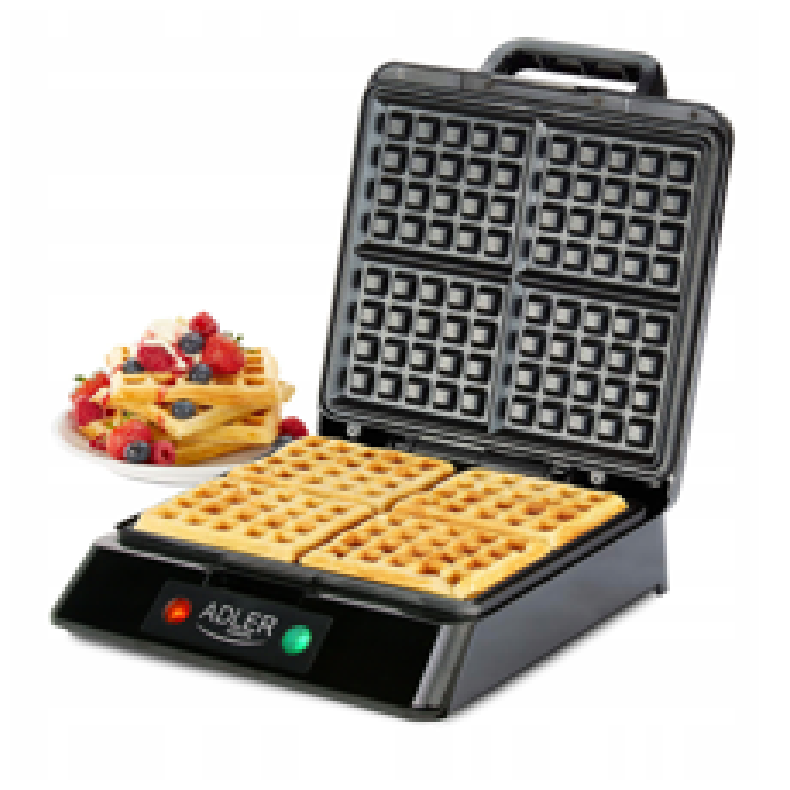

In [21]:
img = get_img(
    "https://a.allegroimg.com/original/11015c/21543e9c433eb395b064ac06336f/GOFROWNICA-4-CHRUPIACE-GOFRY-DUZA-MOC-1500W-AD3036",
    color=True,
    size=224,
)
display(img)

In [22]:
if isinstance(img, np.ndarray):
    img = torch.Tensor(img).float().permute(2, 1, 0).unsqueeze(dim=0)
print(img.shape)

torch.Size([1, 3, 224, 224])


In [23]:
vgg(img).argsort(descending=True)

tensor([[891, 761, 527, 487,  ..., 537, 130, 346, 144]])

In [24]:
for param in vgg.parameters():
    param.requires_grad = False
count_parameters(vgg)

0

In [25]:
vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [26]:
from torchvision.datasets import StanfordCars
from torchvision.transforms import Resize, RandomHorizontalFlip, RandomAffine, RandomCrop, CenterCrop

train_set = StanfordCars(
    "data",
    download=True,
    split="train",
    transform=Compose(
        [
            ToTensor(),
            Resize(224),
            RandomCrop(224),
            RandomHorizontalFlip(),
        ]
    ),
)

test_set = StanfordCars(
    "data", download=True, split="test", transform=Compose([ToTensor(), Resize(224), CenterCrop(224)])
)

classes = test_set.classes

print(f"Train size: {len(train_set)}")
print(f"Test size: {len(test_set)}")
print(f"Classes: {classes}")
print(f"Img shape: {train_set[0][0].shape}")

Train size: 8144
Test size: 8041
Classes: ['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura Integra Type R 2001', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012', 'Audi R8 Coupe 2012', 'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007', 'Audi TT RS Coupe 2012', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', '

In [27]:
vgg.classifier.pop(6)
vgg.classifier.append(nn.Linear(in_features=4096, out_features=len(classes)))
vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=196, bias=True)
)

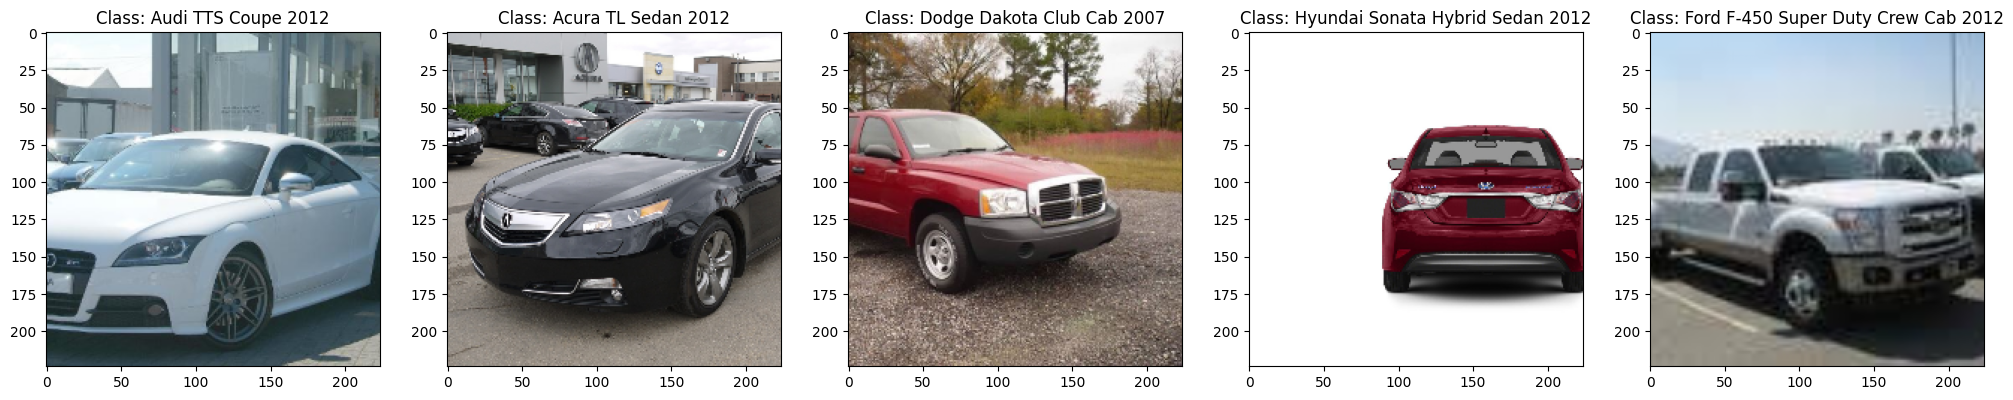

In [28]:
fig, axs = plt.subplots(ncols=5, figsize=(25, 5))
for i, ax in enumerate(axs):
    img, label = train_set[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Class: {classes[label]}")

In [29]:
train(vgg, train_set, batch_size=16)

KeyboardInterrupt: 